In [2]:
import os

os.chdir('/home/yz979/code/kaggle-perturbation/')
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

train_path = 'data/de_train.parquet'
submit_path = 'data/id_map.parquet'

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
import networkx as nx

from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Union, Optional
from sklearn.preprocessing import StandardScaler

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.nn.norm import BatchNorm, GraphNorm
from torch.utils.data import Dataset, random_split

In [60]:
class TabularGraphDataset(Dataset):
    def __init__(self, df, cond_cols, target_cols, perturb_key, edge_index=None, edge_attr=None, scaler=None):
        self.df = df
        self.cond_cols = cond_cols
        self.perturb_key = perturb_key
        self.target_cols = target_cols
        self.cat_dict = {}
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.scaler = scaler

        for cond_col in cond_cols:
            unique_values = df[cond_col].unique()
            self.cat_dict[cond_col] = {val: i for i, val in enumerate(unique_values)}
        
        unique_values = df[perturb_key].unique()
        self.cat_dict[perturb_key] = {val: i for i, val in enumerate(unique_values)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        ret_dict = {}
        for cond_col in self.cond_cols:
            ret_dict[cond_col] = torch.tensor(self.cat_dict[cond_col][row[cond_col]])
        ret_dict[self.perturb_key] = torch.tensor(self.cat_dict[self.perturb_key][row[self.perturb_key]])
        target = torch.tensor(row[self.target_cols].values.astype(np.float32)) if self.target_cols else torch.tensor([0])
        return Data(x=None, edge_index=self.edge_index, edge_attr=self.edge_attr, **ret_dict), target

    def set_graph(self, edge_index, edge_attr):
        self.edge_index = edge_index
        self.edge_attr = edge_attr

    def encode(self, val, col):
        return self.cat_dict[col][val]

    def decode(self, val, col):
        return list(self.cat_dict[col].keys())[val]

    def vocab_size(self, col):
        return len(self.cat_dict[col])

def validate_config(dataset, config):
    config['perturb_key'] = dataset.perturb_key
    for cond_col in dataset.cond_cols:
        config[f'num_{cond_col}s'] = dataset.vocab_size(cond_col)
    config[f'num_{dataset.perturb_key}s'] = dataset.vocab_size(dataset.perturb_key)
    config['num_targets'] = len(dataset.target_cols)
    config['conditions'] = dataset.cond_cols
    return config

def load_dataset(
    path,
    cond_cols = ['cell_type'],
    perturb_key = 'perturb',
    col_map = {'cell_type': 'cell_type', 'sm_lincs_id': 'perturb'},
    is_test = False,
    scaler = None,
    cat_dict = None,
):
    df = pd.read_parquet(path)
    df = df.rename(columns=col_map)
    target_cols = df.iloc[:, 5:].columns.tolist() if not is_test else None
    if scaler is None:
        scaler = StandardScaler()
        df.iloc[:, 5:] = scaler.fit_transform(df.iloc[:, 5:])
    ds = TabularGraphDataset(df, cond_cols, target_cols, perturb_key, scaler=scaler)
    if cat_dict:
        ds.cat_dict = cat_dict
    return ds

@dataclass
class GeneSimNetwork():
    G: nx.DiGraph
    edge_index: torch.Tensor
    edge_weight: torch.Tensor
    
    @classmethod
    def from_edges(
        cls,
        edge_list: pd.DataFrame,
        gene_list: List,
        node_map: Dict[str, int],
        ) -> "GeneSimNetwork":
        """
        Generate gene similarity network from edge list

        Args:
            edge_list (pd.DataFrame): edge list of the network
            gene_list (list): list of gene names
            node_map (dict): dictionary mapping gene names to node indices

        Returns:
            GeneSimNetwork: gene similarity network
        """
        G = nx.from_pandas_edgelist(edge_list, source='source',
                                    target='target', edge_attr=['importance'],
                                    create_using=nx.DiGraph())
        for n in gene_list:
            if n not in G.nodes():
                G.add_node(n)

        to_remove = []
        for n in G.nodes():
            if n not in gene_list:
                to_remove.append(n)
        
        for n in to_remove:
            G.remove_node(n)

        edge_index_ = [(node_map[e[0]], node_map[e[1]]) for e in G.edges]

        edge_index = torch.tensor(edge_index_, dtype=torch.long).T
        
        edge_attr = nx.get_edge_attributes(G, 'importance') 
        importance = np.array([edge_attr[e] for e in G.edges])
        edge_weight = torch.Tensor(importance)
        
        return cls(G, edge_index, edge_weight)

def load_gene_network(path, gene_list, node_map, threshold=0.5):
    edge_list = pd.read_csv(path)
    print('Number of edges before filtering: ', len(edge_list))
    edge_list = edge_list[edge_list['importance'] > threshold]
    print('Number of edges after filtering: ', len(edge_list))
    return GeneSimNetwork.from_edges(edge_list, gene_list, node_map)

In [5]:
def mrrmse_loss(predicted, actual):
    squared_error = (predicted - actual) ** 2
    rowwise_mse = torch.mean(squared_error, dim=1)
    rowwise_rmse = torch.sqrt(rowwise_mse)
    mrrmse = torch.mean(rowwise_rmse)
    return mrrmse

def train_epoch(model, optimizer, dataloader, device):
    model.train()
    total_loss = 0
    for i, (data, target) in enumerate(dataloader):
        data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(**data.to_dict())
        loss = mrrmse_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            data.to(device)
            target = target.to(device)
            output = model(**data.to_dict())
            loss = mrrmse_loss(output, target)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [95]:
class ConditionEncoder(nn.Module):
    def __init__(self, config, condition):
        super(ConditionEncoder, self).__init__()
        self.config = config
        self.condition = condition
        self.embeddings = nn.Embedding(self.config[f'num_{self.condition}s'], self.config['embed_size'])
        self.encoder = nn.Sequential(
            nn.Linear(self.config['embed_size'], self.config['hidden_size']),
            nn.BatchNorm1d(self.config['hidden_size']) if self.config.get('batch_norm') else nn.Identity(),
            nn.Dropout(self.config['dropout']),
        )

    def set_embedding(self, embedding, freeze=True):
        self.embeddings = nn.Embedding.from_pretrained(embedding, freeze=freeze)

    def forward(self, x):
        return self.encoder(self.embeddings(x))

class PerturbationEncoder(nn.Module):
    def __init__(self, config, condition):
        super(PerturbationEncoder, self).__init__()
        raise NotImplementedError

class CellEncoder(nn.Module):
    perturb_encoder_cls = ConditionEncoder  # PerturbationEncoder is not implemented yet (TODO)

    def __init__(self, config):
        super(CellEncoder, self).__init__()
        self.config = config
        self.cell_embedding = nn.Parameter(torch.empty(1, self.config['num_targets'], self.config['embed_size']))  # replace with better embedding
        self.encoder = nn.Sequential(
            nn.Linear(self.config['embed_size'], self.config['hidden_size']),
            nn.LayerNorm(self.config['hidden_size']) if self.config.get('layer_norm') else nn.Identity(),
            nn.Dropout(self.config['dropout']),
        )
        for condition in self.config['conditions']:
            setattr(self, f'{condition}_encoder', ConditionEncoder(self.config, condition))
        self.perturb_encoder = self.perturb_encoder_cls(self.config, config['perturb_key'])
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.cell_embedding)

    def set_cell_embedding(self, cell_embedding, freeze=True):
        self.cell_embedding = nn.Parameter(cell_embedding, requires_grad=not freeze)

    def forward(self, **kwargs):
        cell_embedding = self.cell_embedding
        condition_embedding = torch.cat([
            getattr(self, f'{condition}_encoder')(kwargs[condition]).unsqueeze(1)
            for condition in self.config['conditions']
            ], dim=1)
        condition_embedding = condition_embedding.sum(dim=1, keepdim=True)
        perturb_embedding = self.perturb_encoder(kwargs[self.config['perturb_key']]).unsqueeze(1)
        return self.encoder(cell_embedding), condition_embedding, perturb_embedding

class ValueDecoder(nn.Module):
    def __init__(self, config):
        super(ValueDecoder, self).__init__()
        self.config = config
        self.decoder = nn.Sequential(
            nn.Linear(self.config['hidden_size'], self.config['hidden_size'] * 2),
            BatchNorm(self.config['num_targets']) if self.config.get('batch_norm') else nn.Identity(),
            nn.Dropout(self.config['dropout']),
            config['activation'],
            nn.Linear(self.config['hidden_size'] * 2, self.config['hidden_size']),
            BatchNorm(self.config['num_targets']) if self.config.get('batch_norm') else nn.Identity(),
            nn.Dropout(self.config['dropout']),
            config['activation'],
            nn.Linear(self.config['hidden_size'], 1),
        )

    def forward(self, x):
        return self.decoder(x).squeeze(-1)

class GCNLayer(nn.Module):
    def __init__(self, config):
        super(GCNLayer, self).__init__()
        self.config = config
        self.graph_conv_1 = GCNConv(self.config['hidden_size'], self.config['hidden_size'])
        self.graph_conv_2 = GCNConv(self.config['hidden_size'], self.config['hidden_size'])
        self.dropout = nn.Dropout(self.config['dropout'])
        self.act_fn = config['activation']
        
        self.batch_norm_1 = BatchNorm(self.config['num_targets']) if self.config.get('batch_norm') else nn.Identity()
        self.batch_norm_2 = BatchNorm(self.config['num_targets']) if self.config.get('batch_norm') else nn.Identity()

    def forward(self, x, edge_index, edge_attr=None):
        res = x
        x = self.batch_norm_1(self.dropout(self.act_fn(self.graph_conv_1(x, edge_index, edge_attr))))
        x = self.batch_norm_2(self.dropout(self.act_fn(self.graph_conv_2(x, edge_index, edge_attr))))
        return x + res

class TransformerLayer(nn.Module):
    def __init__(self, config):
        super(TransformerLayer, self).__init__()
        self.config = config
        self.attn = nn.MultiheadAttention(self.config['hidden_size'], self.config['num_heads'])
        self.layer_norm_1 = nn.LayerNorm(self.config['hidden_size'])
        
        self.ffn = nn.Sequential(
            nn.Linear(self.config['hidden_size'], self.config['hidden_size'] * 4),
            nn.Dropout(self.config['dropout']),
            nn.GELU(), 
            nn.Linear(self.config['hidden_size'] * 4, self.config['hidden_size']),
        )
        self.layer_norm_2 = nn.LayerNorm(self.config['hidden_size'])

    def forward(self, x):
        x = self.attn(x, x, x)[0] + x
        x = self.layer_norm_1(x)
        x = self.ffn(x) + x
        x = self.layer_norm_2(x)
        return x

class DERegressor(nn.Module):
    def __init__(self, config):
        super(DERegressor, self).__init__()
        self.config = config
        self.cell_encoder = CellEncoder(self.config)
        self.value_decoder = ValueDecoder(self.config)
        
        self.w_x = nn.Parameter(torch.empty(self.config['num_targets'], 1))
        self.w_c = nn.Parameter(torch.empty(1, self.config['hidden_size']))
        self.w_p = nn.Parameter(torch.empty(1, self.config['hidden_size']))

        self.edge_index = nn.Parameter(None, requires_grad=False)
        self.edge_attr = nn.Parameter(None, requires_grad=False)
        if self.config['model_type'] == 'gcn':
            self.gcn_layers = nn.ModuleList([GCNLayer(self.config) for _ in range(self.config['num_layers'])])
        elif self.config['model_type'] == 'transformer':
            self.transformer_layers = nn.ModuleList([TransformerLayer(self.config) for _ in range(self.config['num_layers'])])
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.w_x)
        nn.init.xavier_uniform_(self.w_c)
        nn.init.xavier_uniform_(self.w_p)
    
    def forward(self, **kwargs):
        x, c, p = self.cell_encoder(**kwargs)
        x = x * self.w_x + c * self.w_c + p * self.w_p
        if self.config['model_type'] == 'gcn':
            for gcn_layer in self.gcn_layers:
                x = gcn_layer(x, self.edge_index, self.edge_attr)
        elif self.config['model_type'] == 'transformer':
            for transformer_layer in self.transformer_layers:
                x = transformer_layer(x)
        else:
            raise NotImplementedError
        return self.value_decoder(x)

    def set_cell_embedding(self, cell_embedding, freeze=True):
        self.cell_encoder.set_cell_embedding(cell_embedding, freeze=freeze)

    def set_condition_embedding(self, condition, condition_embedding, freeze=True):
        getattr(self.cell_encoder, f'{condition}_encoder').set_embedding(condition_embedding, freeze=freeze)
    
    def set_graph(self, edge_index, edge_attr):
        self.edge_index = nn.Parameter(edge_index, requires_grad=False)
        self.edge_attr = nn.Parameter(edge_attr, requires_grad=False)

Number of edges before filtering:  15801928
Number of edges after filtering:  613872
Number of nodes:  18211
Number of edges:  613872
Number of connected components:  8809
Number of isolated nodes:  5531


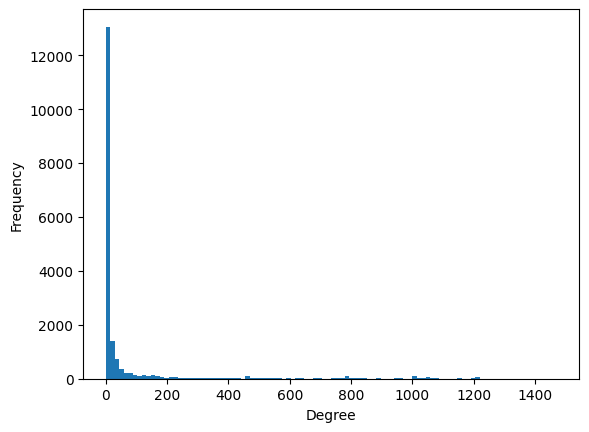

In [94]:
dataset = load_dataset(train_path)
submission = load_dataset(submit_path, is_test=True, cat_dict=dataset.cat_dict, scaler=dataset.scaler)

gene_list = dataset.df.columns[5:].tolist()
node_map = {gene: i for i, gene in enumerate(gene_list)}
gene_sim_network = load_gene_network('data/grn/go.csv', gene_list, node_map, threshold=0.3)

# statistics of gene similarity network
print('Number of nodes: ', gene_sim_network.G.number_of_nodes())
print('Number of edges: ', gene_sim_network.G.number_of_edges())
print('Number of connected components: ', nx.number_weakly_connected_components(gene_sim_network.G))
print('Number of isolated nodes: ', len(list(nx.isolates(gene_sim_network.G))))
# degree distribution
degrees = [d for n, d in gene_sim_network.G.degree()]
plt.hist(degrees, bins=100)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [110]:
model_config = {
    'hidden_size': 256,
    'embed_size': 128,
    'activation': nn.LeakyReLU(),
    'num_layers': 2,
    'num_heads': 8,
    'batch_norm': True,
    'layer_norm': False,
    'dropout': 0.2,
    'model_type': 'gcn',
}
model_config = validate_config(dataset, model_config)

train_dataset, val_dataset = random_split(dataset, [int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

geneformer_embeddings = torch.load('models/geneformer_embeddings_.pt')
chemberta_embeddings = torch.load('models/chemberta_embeddings.pt')

In [117]:
experiment_name = 'grn_model_3'

# model = DERegressor(model_config)
# model.w_p.data *= 2
# model.w_x.data *= 5
model.set_cell_embedding(geneformer_embeddings, freeze=True)
model.set_condition_embedding('perturb', chemberta_embeddings, freeze=True)
model.set_graph(gene_sim_network.edge_index, gene_sim_network.edge_weight)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-4)

model = model.to(device)
best_val_loss = np.inf
for epoch in range(100):
    train_loss = train_epoch(model, optimizer, train_loader, device)
    val_loss = validate_epoch(model, val_loader, device)
    print(f'Epoch {epoch} train loss: {train_loss} val rmse: {val_loss}')
    scheduler.step()
    print(torch.norm(model.w_x), torch.norm(model.w_c), torch.norm(model.w_p))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f'Saving model with val loss {val_loss}')
        torch.save(model.state_dict(), f'models/{experiment_name}.pt')

Epoch 0 train loss: 0.582655388039428 val rmse: 0.6380996964871883
tensor(4.5917, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(1.7043, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(2.8193, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Saving model with val loss 0.6380996964871883
Epoch 1 train loss: 0.5877190205183896 val rmse: 0.5614994913339615
tensor(4.6300, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(1.7500, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(2.8033, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Saving model with val loss 0.5614994913339615
Epoch 2 train loss: 0.5812996602677679 val rmse: 0.5966787822544575
tensor(4.7135, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(1.7292, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(2.8166, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch 3 train loss: 0.5820647408435871 val rmse: 0.588374026119709
tensor(4.6509, de

In [118]:
torch.save(model.state_dict(), f'models/{experiment_name}.pt')
model = DERegressor(model_config)
model.set_graph(gene_sim_network.edge_index, gene_sim_network.edge_weight)
model.load_state_dict(torch.load('models/grn_model_3.pt'))
model = model.to(device)
test_loader = DataLoader(submission, batch_size=4, shuffle=False)

In [119]:
# submit
model.eval()
preds = []
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data.to(device)
        output = model(**data.to_dict())
        preds.append(output.cpu().numpy())

preds = np.concatenate(preds)
preds = dataset.scaler.inverse_transform(preds)
preds = pd.DataFrame(preds, columns=dataset.target_cols)
preds.to_csv('data/submission_6.csv', index_label='id')
preds

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.146269,0.183023,0.332441,0.414301,0.672281,0.552283,-0.060240,0.301165,-0.063933,0.086928,...,-0.049229,0.065833,-0.012736,0.131011,0.413950,0.221799,0.263083,0.247864,-0.270937,-0.002731
1,0.045753,0.091397,0.031774,0.109496,0.191179,0.234520,-0.080836,0.153269,-0.087724,0.087088,...,-0.050081,-0.024475,-0.079846,0.055823,0.221112,0.127865,0.167732,0.124091,-0.178990,-0.073314
2,0.213900,0.114297,-0.014126,0.085559,0.588788,0.960837,-0.073110,0.124631,-0.089561,0.087334,...,-0.035062,-0.044204,-0.073328,0.133334,0.312190,0.185615,0.154190,0.070604,-0.153526,-0.124553
3,0.033717,0.093775,0.022903,0.068832,0.216591,0.148574,-0.084055,0.156686,-0.041752,0.087111,...,-0.031935,-0.030856,-0.104787,-0.005999,0.166350,0.132469,0.169434,0.182007,-0.230734,-0.034873
4,0.147944,0.168414,0.024061,0.035586,0.469285,0.446196,-0.050396,0.219444,-0.017575,0.087426,...,-0.022863,0.039758,-0.061425,0.113763,0.261257,0.199587,0.168443,0.201024,-0.209801,-0.049670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.053958,-0.113918,-0.046797,0.070163,1.226450,-0.026877,-0.080774,-0.009201,-0.172793,0.088712,...,-0.117756,-0.183555,-0.215538,-0.128316,0.234174,0.043567,0.065664,0.037525,-0.142958,-0.127991
251,-0.016329,-0.151038,-0.178194,0.013775,1.984082,-0.246001,-0.108613,-0.082603,-0.076495,0.088168,...,-0.051949,-0.156913,-0.268021,-0.191560,0.150827,0.027597,0.005115,-0.055681,-0.092981,-0.190351
252,0.088451,-0.104633,-0.292230,-0.144710,2.637277,0.151753,-0.108687,-0.071291,-0.119444,0.088254,...,-0.097905,-0.214567,-0.259252,-0.116624,0.242646,0.015748,-0.045661,-0.141710,-0.110951,-0.204862
253,2.827626,1.024067,-4.059803,2.349225,17.326069,4.039629,0.623714,0.180134,2.420457,0.087822,...,0.073284,0.612915,-3.970440,-0.511649,1.468711,-1.123937,-1.454470,0.800975,-0.220075,-0.028759


In [125]:
# submission.df.perturb == submission.decode(15, 'perturb')
find = submission.df[submission.df.perturb == submission.decode(15, 'perturb')]
find

,cell_type,sm_name,perturb
id,,,
126,B cells,Vorinostat,LSM-3828
253,Myeloid cells,Vorinostat,LSM-3828


In [126]:
preds.iloc[find.index]

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
126,0.187844,0.343249,-1.367830,-0.624914,2.002171,0.418658,0.221087,0.227081,2.394212,0.087044,...,0.129910,0.221945,-1.98317,-0.009505,0.102313,0.055104,-0.459282,0.630109,-0.268355,-0.082340
253,2.827626,1.024067,-4.059803,2.349225,17.326069,4.039629,0.623714,0.180134,2.420457,0.087822,...,0.073284,0.612915,-3.97044,-0.511649,1.468711,-1.123937,-1.454470,0.800975,-0.220075,-0.028759


In [116]:
pred_ = pd.read_csv('data/submission_5.csv')
pred_

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.157851,0.135139,0.064579,0.188614,0.246985,0.129225,-0.205016,0.159521,-0.132249,...,-0.120751,-0.119468,-0.055896,-0.013762,0.252637,0.194140,0.214614,0.097543,-0.469122,-0.143820
1,1,0.082970,0.112493,0.016122,0.150402,0.242833,0.162413,-0.177303,0.130744,-0.135339,...,-0.110065,-0.138271,-0.091429,-0.037659,0.190040,0.114548,0.159004,0.075738,-0.352956,-0.133433
2,2,0.086733,0.106412,0.018158,0.150171,0.226735,0.199774,-0.161684,0.133260,-0.131192,...,-0.103275,-0.134534,-0.091236,-0.031357,0.194296,0.116869,0.160172,0.077250,-0.335472,-0.131992
3,3,0.051763,0.067409,-0.025391,0.013669,0.008115,0.049289,-0.155272,0.105142,-0.134851,...,-0.089427,-0.113620,-0.090622,-0.036129,0.144817,0.089914,0.145952,0.108163,-0.242637,-0.141276
4,4,0.054975,0.057908,-0.013780,0.038065,0.045544,0.077910,-0.145470,0.100929,-0.135718,...,-0.094463,-0.127061,-0.106618,-0.045987,0.147557,0.083280,0.135690,0.073483,-0.270784,-0.155530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.009482,0.043044,-0.058341,-0.033009,-0.093903,-0.090123,-0.132484,0.072513,-0.140553,...,-0.074358,-0.113390,-0.108952,-0.058431,0.086136,0.043518,0.118689,0.097737,-0.131085,-0.139192
251,251,0.182772,0.117246,0.048263,0.107544,0.247084,0.418682,-0.143986,0.158732,-0.110476,...,-0.087298,-0.094408,-0.057521,0.017400,0.249831,0.187176,0.209753,0.115751,-0.366013,-0.140920
252,252,-0.043379,-0.004612,-0.069868,-0.039644,-0.113420,-0.117409,-0.109536,0.040984,-0.147273,...,-0.069852,-0.132072,-0.144296,-0.085587,0.052804,0.003479,0.075373,0.049226,-0.096919,-0.155979
253,253,0.443533,0.528896,0.447688,0.966563,0.989150,0.925471,-0.064117,0.476835,-0.064779,...,-0.058895,0.321025,0.264615,0.296434,0.621609,0.593143,0.443181,0.285706,-0.514714,0.033446


In [35]:
preds

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.218221,0.179731,-0.054798,0.024871,0.493190,0.581067,-0.055398,0.232303,-0.069473,0.001176,...,0.009535,0.052298,-0.105074,0.135251,0.341514,0.257881,0.153122,0.099098,-0.224445,-0.131643
1,0.146980,0.038844,-0.144263,-0.234001,0.115186,0.338515,-0.070514,0.154567,-0.093607,-0.010897,...,-0.112410,-0.008791,-0.160951,0.059692,0.214382,0.146892,0.106424,0.080884,-0.237877,-0.148247
2,0.260201,0.128910,0.008374,-0.068510,0.356836,0.640791,-0.032256,0.253137,-0.039208,0.028447,...,-0.034453,0.077636,-0.067954,0.163916,0.350582,0.258399,0.176241,0.123509,-0.196821,-0.107288
3,0.252309,0.121778,-0.002467,-0.081616,0.337699,0.623014,-0.033744,0.247436,-0.040560,0.030770,...,-0.040627,0.072673,-0.075436,0.157450,0.341365,0.250930,0.171957,0.122709,-0.197713,-0.109039
4,0.179937,0.068156,-0.097399,-0.180143,0.193829,0.445006,-0.053160,0.188950,-0.071118,0.021154,...,-0.087039,0.019429,-0.134014,0.092073,0.258866,0.186053,0.130042,0.099978,-0.215229,-0.130735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.262735,0.137643,0.010280,-0.052465,0.380265,0.651925,-0.032190,0.257872,-0.038919,0.032956,...,-0.026895,0.081294,-0.067910,0.166742,0.360593,0.266977,0.178082,0.123737,-0.195710,-0.107242
251,0.229755,0.119831,-0.035955,-0.085194,0.332474,0.576855,-0.044853,0.230195,-0.055966,0.015955,...,-0.042312,0.057204,-0.094581,0.140514,0.324180,0.237511,0.158389,0.110620,-0.211132,-0.120791
252,0.219246,0.111294,-0.050836,-0.100878,0.309572,0.547538,-0.047613,0.222076,-0.060479,0.012676,...,-0.049701,0.049368,-0.101029,0.127463,0.312100,0.227682,0.153151,0.106363,-0.215378,-0.124312
253,0.266777,0.198003,0.006471,0.058443,0.542213,0.705397,-0.041422,0.273030,-0.048167,0.010054,...,0.025350,0.090661,-0.062945,0.179200,0.396374,0.299574,0.183930,0.114505,-0.214198,-0.116457
